In [41]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torchvision.utils as vutils
!pip install -U spacy
!python -m spacy download en_core_web_md


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [42]:
import spacy
nlp = spacy.load("en_core_web_md")



# Generator network
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, ngf, nc, text_embedding_dim):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Linear(text_embedding_dim, nz)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz * 2, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        text_embedding = self.label_embedding(text_embedding)
        text_embedding = text_embedding.unsqueeze(-1).unsqueeze(-1)
        combined_input = torch.cat((noise, text_embedding), 1)
        return self.main(combined_input)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [43]:
class CustomDataset(Dataset):
    def __init__(self, root_image_dir, root_text_dir, transform=None):
        self.root_image_dir = root_image_dir
        self.root_text_dir = root_text_dir
        self.image_files = os.listdir(root_image_dir)
        self.text_files = os.listdir(root_text_dir)
        self.transform = transform

    def __len__(self):
        return min(len(self.image_files), len(self.text_files))

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        text_name = os.path.join(self.root_text_dir, self.text_files[idx])
        with open(text_name, 'r') as file:
            description = file.read()

        return image, description

nlp = spacy.load("en_core_web_md")

def encode_sentence(sentence):
    with torch.no_grad():
        tokenized = nlp(sentence)
        word_embeddings = [token.vector for token in tokenized if token.is_alpha]
        if word_embeddings:
            encoded_vector = torch.tensor(np.mean(word_embeddings, axis=0), dtype=torch.float32)
            return encoded_vector[:nz] if encoded_vector.size(0) > nz else torch.cat((encoded_vector, torch.zeros(nz - encoded_vector.size(0))))
        else:
            return torch.zeros(nz, dtype=torch.float32)


In [44]:
batch_size = 16
image_size = 64
nc = 3
nz = 128
ngf = 64
ndf = 64
num_epochs = 200
text_embedding_dim = nz

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

sedan_dataset = CustomDataset(
    root_image_dir='/kaggle/input/car-dataset/cars_dataset/sedan_images',
    root_text_dir='/kaggle/input/car-dataset/cars_dataset/sedan_names',
    transform=transform
)

suv_dataset = CustomDataset(
    root_image_dir='/kaggle/input/car-dataset/cars_dataset/suv_images',
    root_text_dir='/kaggle/input/car-dataset/cars_dataset/suv_names',
    transform=transform
)

dataloader = DataLoader(sedan_dataset + suv_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = ConditionalGenerator(nz, ngf, nc, text_embedding_dim).to(device)
netD = Discriminator(nc, ndf).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [46]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        images, descriptions = data
        b_size = images.size(0)
        real_images = images.to(device)
        encoded_texts = [encode_sentence(desc).to(device) for desc in descriptions]
        encoded_texts = torch.stack(encoded_texts)

        # Train Discriminator
        netD.zero_grad()
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise, encoded_texts)
        label.fill_(0)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] completed.")
torch.save(netG.state_dict(), 'generator.pth')


Epoch [1/200] completed.
Epoch [2/200] completed.
Epoch [3/200] completed.
Epoch [4/200] completed.
Epoch [5/200] completed.
Epoch [6/200] completed.
Epoch [7/200] completed.
Epoch [8/200] completed.
Epoch [9/200] completed.
Epoch [10/200] completed.
Epoch [11/200] completed.
Epoch [12/200] completed.
Epoch [13/200] completed.
Epoch [14/200] completed.
Epoch [15/200] completed.
Epoch [16/200] completed.
Epoch [17/200] completed.
Epoch [18/200] completed.
Epoch [19/200] completed.
Epoch [20/200] completed.
Epoch [21/200] completed.
Epoch [22/200] completed.
Epoch [23/200] completed.
Epoch [24/200] completed.
Epoch [25/200] completed.
Epoch [26/200] completed.
Epoch [27/200] completed.
Epoch [28/200] completed.
Epoch [29/200] completed.
Epoch [30/200] completed.
Epoch [31/200] completed.
Epoch [32/200] completed.
Epoch [33/200] completed.
Epoch [34/200] completed.
Epoch [35/200] completed.
Epoch [36/200] completed.
Epoch [37/200] completed.
Epoch [38/200] completed.
Epoch [39/200] comple

In [49]:
from torchvision.utils import save_image


def generate_image_from_description(description, save_dir="generated_images"):
    netG.eval()
    description_vector = encode_sentence(description).to(device)
    noise = torch.randn(1, nz, 1, 1, device=device)
    with torch.no_grad():
        image = netG(noise, description_vector.unsqueeze(0)).squeeze(0).cpu()
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{description.replace(' ', '_')}.png")
    save_image(image, save_path, normalize=True)
    print(f"Image saved to {save_path}")

descriptions = [
    "a red sedan car",
    "a white SUV car",
]

for desc in descriptions:
    generate_image_from_description(desc, save_dir="output_images")


Image saved to output_images/a_red_sedan_car.png
Image saved to output_images/a_white_SUV_car.png


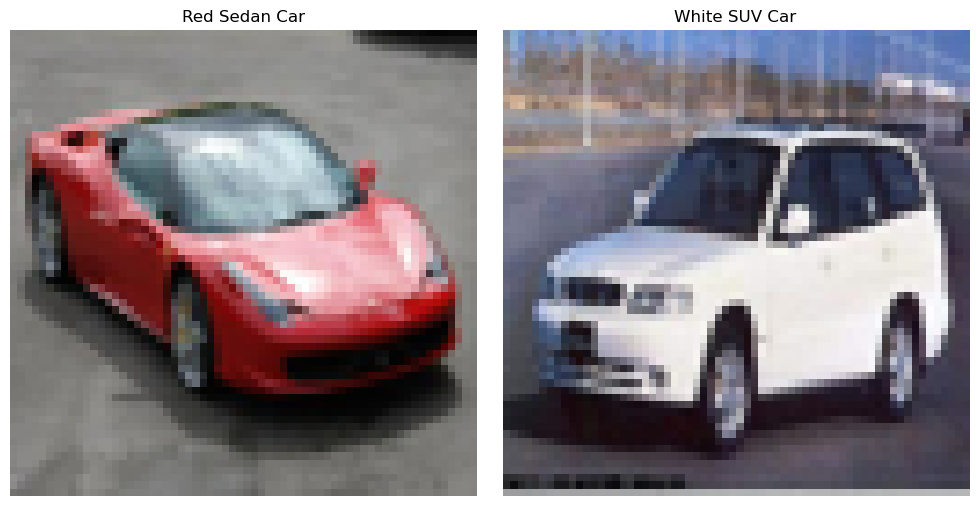

In [1]:
#display the saved images


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# File paths
image1_path = './output_images/a_red_sedan_car.png'
image2_path = './output_images/a_white_SUV_car.png'

# Load and display the images
image1 = mpimg.imread(image1_path)
image2 = mpimg.imread(image2_path)

plt.figure(figsize=(10, 5))

# Display first image
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Red Sedan Car')
plt.axis('off')  # Hide axes

# Display second image
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('White SUV Car')
plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


pth_link - https://drive.google.com/file/d/1PCCVCvyzouac6puKsDF5e3ZsqF-fedGT/view?usp=sharing